In [1]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense, GRU
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Configuration

batch_size=256
epochs=100
latent_dim=64
num_samples=900
data_path = "data/hindi.txt"

In [3]:
# Vectorize the data.

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters=sorted(list(input_characters))
target_characters=sorted(list(target_characters))

num_encoder_tokens=len(input_characters)
num_decoder_tokens=len(target_characters)

max_encoder_seq_length=max([len(txt) for txt in input_texts])
max_decoder_seq_length=max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index=dict(
    [(char,i) for i, char in enumerate(input_characters)])
target_token_index=dict(
[(char,i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

Number of samples: 900
Number of unique input tokens: 67
Number of unique output tokens: 77
Max sequence length for inputs: 25
Max sequence length for outputs: 60


In [4]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [5]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
lstm = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
lstm.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
lstm_hist = lstm.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
3/3 [==============================] - 3s 268ms/step - loss: 4.2287 - accuracy: 0.2280 - val_loss: 4.1302 - val_accuracy: 0.6018
Epoch 2/100
3/3 [==============================] - 0s 27ms/step - loss: 3.9891 - accuracy: 0.6973 - val_loss: 3.7338 - val_accuracy: 0.6241
Epoch 3/100
3/3 [==============================] - 0s 27ms/step - loss: 3.2097 - accuracy: 0.7034 - val_loss: 2.6170 - val_accuracy: 0.6214
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 2.1712 - accuracy: 0.7023 - val_loss: 2.2087 - val_accuracy: 0.6214
Epoch 5/100
3/3 [==============================] - 0s 26ms/step - loss: 1.8240 - accuracy: 0.7023 - val_loss: 2.0909 - val_accuracy: 0.6214
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 1.7069 - accuracy: 0.7023 - val_loss: 2.0397 - val_accuracy: 0.6214
Epoch 7/100
3/3 [==============================] - 0s 28ms/step - loss: 1.6482 - accuracy: 0.7023 - val_loss: 2.0048 - val_accuracy: 0.6214
Epoch 8/100
3/3 [==

In [6]:
lstm.save('lstm.keras')

In [7]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [8]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(([target_seq] + states_value), verbose = 0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [9]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = GRU(latent_dim, return_state=True)
encoder_outputs, state_h = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _= decoder_gru(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [10]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
gru = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
gru.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
gru_hist = gru.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
3/3 [==============================] - 2s 222ms/step - loss: 4.3446 - accuracy: 0.0205 - val_loss: 4.2338 - val_accuracy: 0.5608
Epoch 2/100
3/3 [==============================] - 0s 25ms/step - loss: 4.1700 - accuracy: 0.6770 - val_loss: 4.0954 - val_accuracy: 0.6153
Epoch 3/100
3/3 [==============================] - 0s 24ms/step - loss: 3.9972 - accuracy: 0.7003 - val_loss: 3.9123 - val_accuracy: 0.6212
Epoch 4/100
3/3 [==============================] - 0s 25ms/step - loss: 3.7436 - accuracy: 0.7023 - val_loss: 3.5762 - val_accuracy: 0.6214
Epoch 5/100
3/3 [==============================] - 0s 25ms/step - loss: 3.1876 - accuracy: 0.7023 - val_loss: 2.5989 - val_accuracy: 0.6214
Epoch 6/100
3/3 [==============================] - 0s 25ms/step - loss: 1.9761 - accuracy: 0.7023 - val_loss: 2.0343 - val_accuracy: 0.6214
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 1.6204 - accuracy: 0.7023 - val_loss: 1.9976 - val_accuracy: 0.6214
Epoch 8/100
3/3 [==

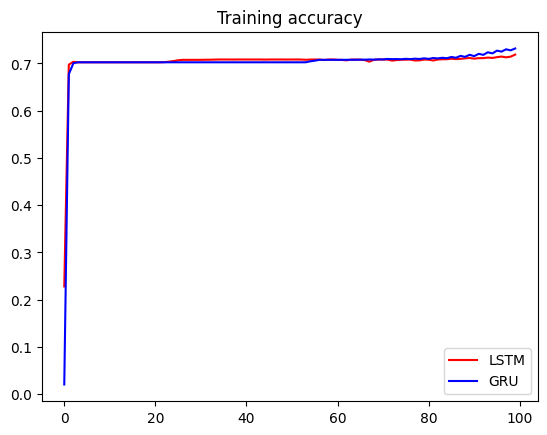

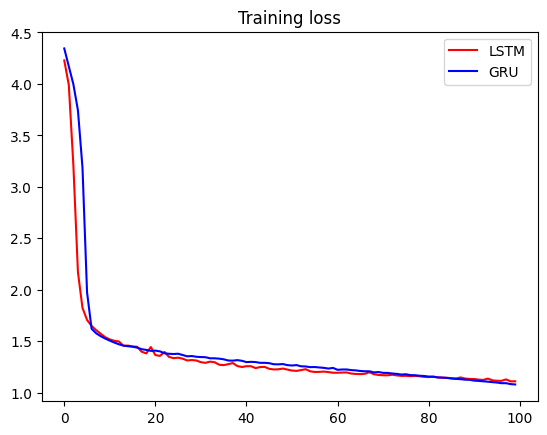

In [12]:
accuracy = lstm_hist.history['accuracy']
loss = lstm_hist.history['loss']
epochs = range(len(accuracy))

accuracy_1 = gru_hist.history['accuracy']
loss_1 = gru_hist.history['loss']
epochs_1 = range(len(accuracy_1))

plt.plot(epochs, accuracy, 'r', label='LSTM')
plt.plot(epochs_1, accuracy_1, 'b', label='GRU')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='LSTM')
plt.plot(epochs_1, loss_1, 'b', label='GRU')
plt.title('Training loss')
plt.legend()
plt.show()